In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import time
import random
import threading as th
from sklearn.feature_extraction.text import CountVectorizer 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import statistics
from random import sample
import warnings
warnings.filterwarnings('ignore')


In [2]:
amazon_reviews = []
amazon_ratings = []
flipkart_reviews = []
flipkart_ratings = []

url1 = "/OnePlus-Glacier-Display-Storage-3800mAH/product-reviews/B07DJHXTLJ/ref=cm_cr_getr_d_paging_btm_prev_1?ie=UTF8&reviewerType=all_reviews&pageNumber=1"
url = 'https://www.amazon.in'
flipkart_url="""https://www.flipkart.com/oneplus-7t-glacier-blue-256-gb/product-reviews/itma74f3aece46b1?pid=MOBFKWSYTHTESNSG&lid=LSTMOBFKWSYTHTESNSGC2V2UD&marketplace=FLIPKART&page="""


def amazon_data_extraction(url1):
    for i in range(1,3):
        html = requests.get(url + url1)
        while html.status_code != 200:
            print('error')
            time.sleep(random.randint(3, 6))
            html = requests.get(url + url1)

        reviews=[]
        try:
            page = BeautifulSoup(html.content, 'lxml')
            review = page.find_all('span',class_='a-size-base review-text review-text-content')
            raw_rating=page.select('div.a-row>a>i>span.a-icon-alt')
            for i in range(10):
                reviews.append(review[i].span.text)
                a=re.sub('[^0-9]',"",str(raw_rating[i]))
                amazon_ratings.append(int(a[0]))
        except TypeError:
            print('oops')

        next_url = page.select('li.a-last>a')
       # global url1
        url1 = next_url[0].attrs['href']
        reviews=cleaning_reviews(reviews)
        for k in reviews:
            amazon_reviews.append(k)

def cleaning_reviews(reviews):
    for i in range(len(reviews)):
        words=re.sub('[^a-zA-Z]+'," ",reviews[i].lower())
        words=word_tokenize(words)
        words=[WordNetLemmatizer().lemmatize(k) for k in words if k not in set(stopwords.words('english'))]
        reviews[i]=" ".join(words)
    return reviews

def sentimence_analysis(reviews):
    sentimence=[]
    for i in reviews:
        if TextBlob(i).sentiment.polarity==0:
            sentimence.append(0)
        elif TextBlob(i).sentiment.polarity>0:
            sentimence.append(1)
        elif TextBlob(i).sentiment.polarity<0:
            sentimence.append(-1)
    return sentimence

def flipkart_data_extraction(url):
    for i in range(1,3):
        html=requests.get(url+str(i))
        while html.status_code!=200:
            print('error')
            time.sleep(random.randint(3,6))
            html=requests.get(url+str(i))

        try:
            reviews=[]
            page=BeautifulSoup(html.content,'lxml')
            review = page.find_all('div',class_='qwjRop')
            rating=page.find_all('div',class_='col _390CkK _1gY8H-')
            for i in range(len(review)):
                reviews.append(review[i].div.div.text)
                flipkart_ratings.append(int(rating[i].find('div',class_='row').text[0]))
        except TypeError:
            print('oops')

        reviews=cleaning_reviews(reviews)
        for k in reviews:
            flipkart_reviews.append(k)

# if __name__ == "__main__":
#     t1=th.Thread(target=amazon_data_extraction, args=(url1,))
#     t2=th.Thread(target=flipkart_data_extraction, args=(flipkart_url,))
#     t1.start()
#     t2.start()
#     t1.join()
#     t2.join()


# s=time.time()
# sentimence = sentimence_analysis(amazon_reviews)
# amazon_data = pd.DataFrame({'comments': amazon_reviews, 'ratings': amazon_ratings, 'sentiments': sentimence})
# # amazon_data.to_csv(r'E:\csv_datas\scraping_reviews/amazon_data.csv')
# print(amazon_data)
# flipkart_data_extraction(flipkart_url)
# flipkart_sentimence = sentimence_analysis(flipkart_reviews)
# flipkart_data = pd.DataFrame({'reviews':flipkart_reviews,'ratings':flipkart_ratings,'sentiments':flipkart_sentimence})
# # flipkart_data.to_csv(r'E:\csv_datas\scraping_reviews/flipcart_data.csv')
# print(flipkart_data)
# # print(f'time  {time.time()-s}')


In [3]:
amazon_data1=pd.read_csv(r'E:\csv_datas\scraping_reviews/amazon_data.csv', usecols=['reviews', 'sentiments'] )
flipkart_data1=pd.read_csv(r'E:\csv_datas\scraping_reviews/flipkart_data.csv', usecols=['reviews', 'sentiments'])

In [4]:
df=pd.concat([amazon_data1,flipkart_data1],  ignore_index=True)

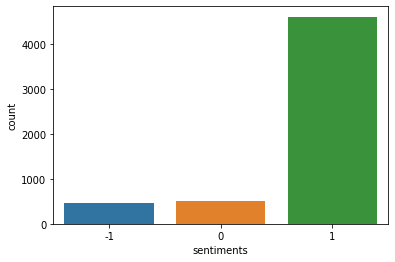

In [5]:
sns.countplot(df.sentiments)

In [6]:
df.loc[df.sentiments==-1].shape, df.loc[df.sentiments==0].shape, df.loc[df.sentiments==1].shape

((473, 2), (507, 2), (4600, 2))

In [7]:
 df.isna().sum()

reviews       4
sentiments    0
dtype: int64

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
 df.isna().sum()

reviews       0
sentiments    0
dtype: int64

In [10]:
df.reset_index(drop=True, inplace=True)


In [11]:
def text_data_conversion(df):
    x=df.reviews
    y=df.sentiments
    cv=CountVectorizer()
    x=cv.fit_transform(x).toarray()
    return x,y

In [12]:
data,target=text_data_conversion(df)
print(data)
print(f'data shape :{data.shape} , target shape :{target.shape}')

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data shape :(5576, 7427) , target shape :(5576,)


In [ ]:
sns.heatmap(data)

In [13]:
st = StandardScaler()
scaled_data=st.fit_transform(data)

In [14]:
pca=PCA()
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'varience')

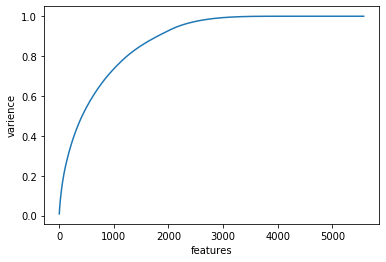

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('features')
plt.ylabel('varience')

In [16]:
pca=PCA(n_components=1600)
data=pca.fit_transform(scaled_data)

In [17]:
data.shape

(5576, 1600)

In [ ]:
from feature_selection import SelectPercentile

In [18]:
stk=StratifiedKFold(n_splits=3)
train_index = []
test_index = []
for i,j in stk.split(data,target):
    train_index.append(i)
    test_index.append(j)


In [19]:
def data_sampling(train_index, l):
    train_data, train_target = [], []
    os=SMOTETomek()
    for i in train_index:
        data_sam,target_sam=os.fit_sample(l[0][i], l[1][i])
        train_data.append(data_sam)
        train_target.append(target_sam)
    return train_data, train_target
        

In [20]:
data_sam,target_sam=data_sampling(train_index, [data, target])

In [21]:
data_sam[1].shape

(9195, 1600)

In [22]:
from sklearn.linear_model import LogisticRegression
lgr =LogisticRegression()
accuracy=[]
for i in range(3):
    lgr.fit(data_sam[i], target_sam[i])
    ypred=lgr.predict(data[test_index[i]])
    accuracy.append(accuracy_score(ypred,target[test_index[i]]))
statistics.mean(accuracy)
    

0.7541339728969108

In [39]:
def input_data_preparation():
    cv=CountVectorizer()
    comment = input('enter comment: ')
    comment = re.sub('[^a-zA-Z]+', " ", (comment.lower()))
    words = word_tokenize(comment)
    words = [WordNetLemmatizer().lemmatize(k) for k in words if k not in set(stopwords.words('english'))]
    comment = " ".join(words)
    comment = sent_tokenize(comment)
    numeric_cmt = cv.fit_transform(comment).toarray()
    numeric_cmt = numeric_cmt.flatten()
    print(numeric_cmt.shape)
    if len(numeric_cmt)<7427:
        numeric_cmt = np.pad(numeric_cmt, (7427-len(numeric_cmt), 0), 'constant')
        print(numeric_cmt.shape)
        return numeric_cmt


In [ ]:
comment = input_data_preparation()
# comment.shape

In [45]:
scaled_comment = st.transform(comment.reshape(1,-1))
scaled_comment
comment = pca.transform(scaled_comment)

In [46]:
lgr.predict(comment)

array([1], dtype=int64)

In [33]:
import pickle

In [34]:
pickle.dump(lgr, open(r'E:\model_deployment\oneplus_sentimental analysis\model.pkl', 'wb'))

In [29]:
# db=open(r'E:\model_deployment\oneplus_sentimental analysis\model2.pkl', 'wb')

In [37]:
pickle.dump(st, open(r'E:\model_deployment\oneplus_sentimental analysis\scaler.pkl', 'wb'))

In [38]:
pickle.dump(pca, open(r'E:\model_deployment\oneplus_sentimental analysis\pca.pkl', 'wb'))